In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score,accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import scale, LabelEncoder

from lightgbm import LGBMClassifier
import lightgbm as lgbm

In [2]:
dataset = pd.read_csv("train_feat_eng.csv")

In [3]:
application_train = pd.read_csv("data/application_train.csv")

In [4]:
index = dataset.columns.isin(application_train.columns)
~index

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,

In [5]:
eng_cols = dataset.columns[~index]
eng_cols

Index(['Unnamed: 0', 'AMT_CREDIT_LIMIT_ACTUAL', 'OVERDUE_DAYS_SUM',
       'TOTAL_ATM_WITHDRAW', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_GOODS_RATIO', 'AMT_CREDIT_INCOME_RATIO', 'NUM_PREV_LOANS',
       'ACTIVE_LOANS_PERCENTAGE', 'DEBT_CREDIT_RATIO'],
      dtype='object')

In [6]:
#number of features to test
len(eng_cols)

10

In [7]:
def model_on_dataset(dataset):
    data = pd.get_dummies(dataset)
    data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    X_train, X_test, y_train, y_test = train_test_split(data.drop('TARGET', 1), data['TARGET'], test_size = .2, random_state=42,shuffle=True)

    lgbm_train = lgbm.Dataset(X_train, y_train)
    max_depths = [x for x in range(3,30,3)]
    max_depths.append(50)
    max_depths.append(100)
    num_leaves = [x for x in range(4,20,2)]
    min_leaf_data = [x for x in range(5,100,9)]
    boost_method = ['gbdt', 'dart']
    unbalanced = [True, False]
    parameters = {
    #'num_leaves': 10,
    #'min_data_in_leaf': 50,
    'max_depth': 5
    }

    estimator = lgbm.train(parameters, train_set=lgbm_train)
    #estimating probabilities
    train_pred = estimator.predict(X_train)
    test_pred = estimator.predict(X_test)

    #converting to binary
    train_pred = np.round(train_pred,0)
    test_pred = np.round(test_pred,0)

    train_acc = accuracy_score(train_pred, y_train)
    train_cm = confusion_matrix(train_pred, y_train)
    train_roc = roc_auc_score(train_pred, y_train)
    test_acc = accuracy_score(test_pred, y_test)
    test_cm = confusion_matrix(test_pred, y_test)
    test_roc = roc_auc_score(test_pred, y_test)
    return train_pred, train_acc, train_cm, test_acc, test_cm, test_roc

    

In [8]:
def test_feature_strength(eng_cols, dataset, application_train):
    train_preds = []
    train_accs = []
    train_cms = []
    test_accs = []
    test_cms = []
    test_rocs = []
    for col in eng_cols:
        app = application_train.copy()
        app[col] = dataset[col]
        train_pred, train_acc, train_cm, test_acc, test_cm, test_roc = model_on_dataset(app)
        train_preds.append(train_pred)
        train_accs.append(train_acc)
        train_cms.append(train_cm)
        test_accs.append(test_acc)
        test_cms.append(test_cm)
        test_rocs.append(test_roc)
        
    return train_preds, train_accs, train_cms, test_accs, train_cms, test_rocs
        

In [9]:
train_preds, train_accs, train_cms, test_accs, train_cms, test_rocs = \
test_feature_strength(eng_cols, dataset, application_train)

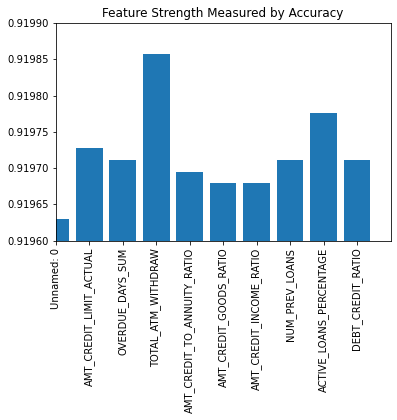

In [10]:
names = list(eng_cols)
values = list(test_accs)


x = np.arange(len(eng_cols))
xmin = 0
xmax = len(eng_cols)
ymin = .9196
ymax = 0.91990
fig, ax = plt.subplots()
plt.bar(x, values)
plt.xticks(x, (eng_cols), rotation='vertical')
plt.axis([xmin,xmax,ymin,ymax])
plt.title("Feature Strength Measured by Accuracy")
plt.savefig("feature_strength_test_acc.png")

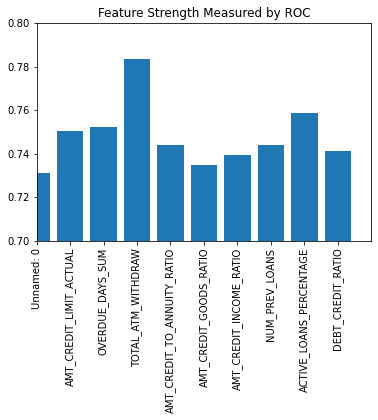

In [11]:
names = list(eng_cols)
values = list(test_rocs)


x = np.arange(len(eng_cols))
xmin = 0
xmax = len(eng_cols)
ymin = .70
ymax = 0.80
fig, ax = plt.subplots()
plt.bar(x, values)
plt.xticks(x, (eng_cols), rotation='vertical')
plt.axis([xmin,xmax,ymin,ymax])
plt.title("Feature Strength Measured by ROC")
plt.savefig("feature_strength_test_roc.png")

In [12]:
data = pd.get_dummies(dataset)
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [13]:
correls = []
counter = -1
cols = data.drop('TARGET', 1).columns
for col in cols:
    counter+=1
    c = data['TARGET'].corr(data[col])
    if c is not None:
        correls.append(c)
    else:
        correls.append(0)

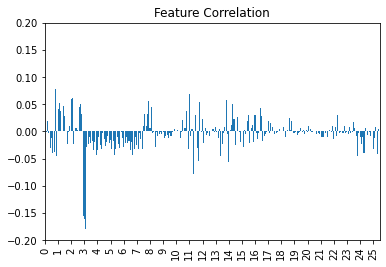

In [16]:
names = list(cols)
values = list(correls)

x = np.arange(len(names))
xmin = 0
xmax = len(names)
ymin = -.2
ymax = 0.2
fig, ax = plt.subplots()
plt.bar(x, values)
plt.xticks(x, (x), rotation='vertical')
#plt.yaxis.set_label_position("right")
plt.axis([xmin,xmax,ymin,ymax])
#red_patch = mpatches.Patch(url=names[5], label=5)
#ax.legend(x, names)
start, end = ax.get_xlim()
stepsize = 10
ax.xaxis.set_ticks(np.arange(start, end, stepsize))
plt.title("Feature Correlation")
plt.savefig("feature_correlation.png")         

In [17]:
correlation_df = pd.DataFrame({'name': names,
'correlation': values})
correlation_df

,name,correlation
0,Unnamed0,-0.002111
1,SK_ID_CURR,-0.002108
2,CNT_CHILDREN,0.019187
3,AMT_INCOME_TOTAL,-0.003982
4,AMT_CREDIT,-0.030369
...,...,...
250,WALLSMATERIAL_MODE_Panel,-0.033119
251,WALLSMATERIAL_MODE_Stonebrick,-0.012657
252,WALLSMATERIAL_MODE_Wooden,0.007946
253,EMERGENCYSTATE_MODE_No,-0.042201


In [18]:
correlation_df.max()

name           YEARS_BUILD_MODE
correlation           0.0782393
dtype: object

In [19]:
correlation_df.min()

name           ACTIVE_LOANS_PERCENTAGE
correlation                  -0.178919
dtype: object

In [20]:
correlation_df.sort_values('correlation').head(10)

,name,correlation
31,EXT_SOURCE_3,-0.178919
30,EXT_SOURCE_2,-0.160472
29,EXT_SOURCE_1,-0.155317
113,ACTIVE_LOANS_PERCENTAGE,-0.079369
140,NAME_EDUCATION_TYPE_Highereducation,-0.056593
117,CODE_GENDER_F,-0.054704
134,NAME_INCOME_TYPE_Pensioner,-0.046209
238,ORGANIZATION_TYPE_XNA,-0.045987
9,DAYS_EMPLOYED,-0.044932
39,FLOORSMAX_AVG,-0.044003


In [21]:
correlation_df.sort_values('correlation').tail(10)

,name,correlation
27,REG_CITY_NOT_WORK_CITY,0.050994
11,DAYS_ID_PUBLISH,0.051457
118,CODE_GENDER_M,0.054713
79,DAYS_LAST_PHONE_CHANGE,0.055218
138,NAME_INCOME_TYPE_Working,0.057481
20,REGION_RATING_CLIENT,0.058899
21,REGION_RATING_CLIENT_W_CITY,0.060893
110,AMT_CREDIT_GOODS_RATIO,0.069427
8,DAYS_BIRTH,0.078239
114,DEBT_CREDIT_RATIO,NaN
